In [1]:
import torch
print("CUDA dostępne:", torch.cuda.is_available())
print("Ilość GPU:", torch.cuda.device_count())
print("Nazwa GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Brak")


CUDA dostępne: True
Ilość GPU: 1
Nazwa GPU: NVIDIA GeForce RTX 3070


In [2]:
from pathlib import Path
import numpy as np, nibabel as nib
import torch, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor, SegformerConfig

# <<< PODAJ SWÓJ FOLDER Z PLIKAMI >>>
data_dir = Path(r"D:\Skany\Dataset\D, E")  # <- zmień
img_path = next(data_dir.glob("*Dose*.nii"))               # np. ... (3).nii
msk_path = next(data_dir.glob("*segmentation*.nii"))       # np. ... segmentation.nii

print("img:", img_path.name)
print("msk:", msk_path.name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target_size = (512, 512)


img: 601 TETNICZA iDose (3) segmentation.nii
msk: 601 TETNICZA iDose (3) segmentation.nii


In [3]:
def load_nifti_safe(p: Path) -> np.ndarray:
    nii = nib.load(str(p))
    hdr = nii.header
    arr = nii.get_fdata(dtype=np.float32)

    # jeśli wyszły same zera / stała → użyj danych nieskalowanych
    if not np.isfinite(arr).any() or np.nanstd(arr) == 0:
        raw = nii.dataobj.get_unscaled().astype(np.float32)
        slope = float(hdr.get('scl_slope', 1.0) or 1.0)
        inter = float(hdr.get('scl_inter', 0.0) or 0.0)
        slope = slope if np.isfinite(slope) and slope != 0.0 else 1.0
        inter = inter if np.isfinite(inter) else 0.0
        arr = raw * slope + inter
    return arr

def to_DHW(a: np.ndarray) -> np.ndarray:
    a = np.asarray(a)
    if a.ndim != 3:
        raise ValueError(f"Spodziewam się 3D, mam {a.shape}")
    # heurystyka ustawiania (D,H,W)
    if a.shape[0] <= min(a.shape[1], a.shape[2]):
        return a
    if a.shape[-1] <= min(a.shape[0], a.shape[1]):
        return np.moveaxis(a, -1, 0)
    return np.moveaxis(a, 2, 0)

img = load_nifti_safe(img_path).astype(np.float32)
msk = nib.load(str(msk_path)).get_fdata().astype(np.int32)

print("raw stats img:", float(img.min()), float(img.max()), float(img.mean()), float(img.std()))

img = to_DHW(img)
msk = to_DHW(msk)

print("shapes (D,H,W):", img.shape, msk.shape)
unique_labels = np.unique(msk).astype(int).tolist()
num_labels = int(max(unique_labels)) + 1
print("etykiety:", unique_labels, " → num_labels:", num_labels)


raw stats img: 0.0 15.0 0.0526026152074337 0.6941153407096863
shapes (D,H,W): (512, 512, 643) (512, 512, 643)
etykiety: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]  → num_labels: 16


In [4]:
class NiftiSlices(Dataset):
    def __init__(self, volume, mask, axis=0, resize_to=(512,512), keep_only_nonempty=True):
        assert volume.shape == mask.shape
        self.imgs = np.moveaxis(volume, axis, 0)     # (N,H,W)
        self.msks = np.moveaxis(mask,   axis, 0)
        self.resize_to = resize_to

        if keep_only_nonempty:
            idx = [i for i in range(len(self.imgs)) if self.msks[i].max() > 0]
            if len(idx) >= 10:
                self.imgs = self.imgs[idx]
                self.msks = self.msks[idx]

    def __len__(self): 
        return len(self.imgs)

    def __getitem__(self, idx):
        # ---- obraz ----
        xx = self.imgs[idx].astype(np.float32)  # (H,W)
        p1, p99 = np.percentile(xx, (1, 99))
        xx = np.clip(xx, p1, p99)
        xx = (xx - xx.min()) / (xx.max() - xx.min() + 1e-8)  # [0,1] per-slice

        x = torch.from_numpy(xx)[None, ...]                  # (1,H,W)
        x = F.interpolate(x[None], size=self.resize_to, mode="bilinear", align_corners=False).squeeze(0)
        x = x.repeat(3, 1, 1).float()                        # (3,H,W) – SegFormer (pretrained) oczekuje 3 kanałów

        # ---- maska ----
        y = torch.from_numpy(self.msks[idx]).long()          # (H,W)
        y = F.interpolate(y[None, None].float(), size=self.resize_to, mode="nearest").squeeze().long()  # (H,W)

        return x, y

dataset = NiftiSlices(img, msk, axis=0, resize_to=target_size)

n_val = max(1, int(0.2*len(dataset)))
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

train_loader = DataLoader(train_set, batch_size=4, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_set,   batch_size=4, shuffle=False, num_workers=0)

xb, yb = next(iter(train_loader))
print("batch x:", xb.shape, xb.dtype, xb.min().item(), xb.max().item())
print("batch y:", yb.shape, yb.dtype, yb.unique()[:10])


batch x: torch.Size([4, 3, 512, 512]) torch.float32 0.0 1.0
batch y: torch.Size([4, 512, 512]) torch.int64 tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [5]:
config = SegformerConfig(
    num_labels=num_labels,
    id2label={i: str(i) for i in range(num_labels)},
    label2id={str(i): i for i in range(num_labels)},
    hidden_sizes=[32, 64, 160, 256],   # B0
    depths=[2, 2, 2, 2],
    sr_ratios=[8, 4, 2, 1],
    patch_sizes=[7, 3, 3, 3],
    decoder_hidden_size=256,
    # num_channels domyślnie = 3 – pasuje do naszego datasetu
)

model = SegformerForSemanticSegmentation(config).to(device)

# „FeatureExtractor” nie robi u nas nic (resize/normalize wyłączyliśmy), ale utrzymujemy dla zgodności API
processor = SegformerFeatureExtractor(do_resize=False, do_normalize=False)

optim = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
epochs = 5


In [6]:
def run_epoch(loader, train=True):
    model.train(train)
    total, n = 0.0, 0
    for x, y in tqdm(loader, leave=False):
        x = x.to(device).float()                 # (B,3,H,W)
        y = y.to(device)                         # (B,H,W)
        outputs = model(pixel_values=x, labels=y)
        loss = outputs.loss

        if train:
            optim.zero_grad()
            loss.backward()
            optim.step()

        total += loss.item() * x.size(0)
        n += x.size(0)
    return total / max(1, n)

for e in range(1, epochs+1):
    tr = run_epoch(train_loader, True)
    vl = run_epoch(val_loader, False)
    print(f"Epoka {e}: train_loss={tr:.4f}  val_loss={vl:.4f}")


Epoka 1: train_loss=nan  val_loss=nan


Epoka 2: train_loss=nan  val_loss=nan


Epoka 3: train_loss=nan  val_loss=nan


Epoka 4: train_loss=nan  val_loss=nan


Epoka 5: train_loss=nan  val_loss=nan


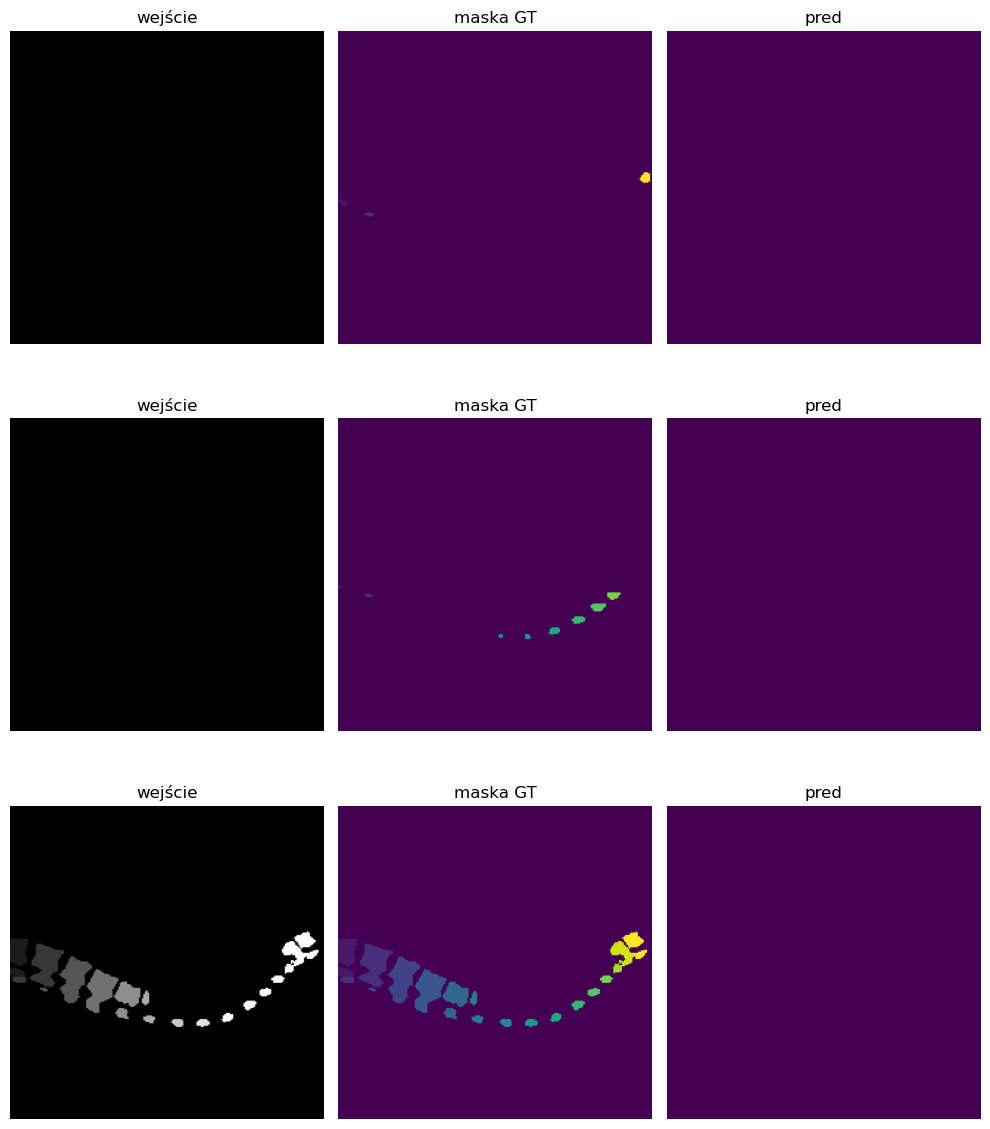

In [7]:
def to01(t):
    t = t - t.min()
    return (t / (t.max() + 1e-8)).cpu().numpy()

model.eval()
with torch.no_grad():
    x, y = next(iter(val_loader))
    x = x.to(device).float()
    logits = model(pixel_values=x).logits  # (B, C, H, W)
    preds = logits.argmax(1).cpu()         # (B, H, W)

k = min(3, x.size(0))
fig, axes = plt.subplots(k, 3, figsize=(10, 4*k))
for i in range(k):
    axes[i,0].imshow(to01(x[i,0].cpu()), cmap='gray'); axes[i,0].set_title("wejście")
    axes[i,1].imshow(y[i].cpu(), vmin=0, vmax=num_labels-1); axes[i,1].set_title("maska GT")
    axes[i,2].imshow(preds[i], vmin=0, vmax=num_labels-1); axes[i,2].set_title("pred")
    for j in range(3): axes[i,j].axis('off')
plt.tight_layout(); plt.show()


In [ ]:
save_dir = Path("segformer_minimal_model")
save_dir.mkdir(exist_ok=True)
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)
print("Zapisano do:", save_dir.resolve())
